# Avellaneda-Stoikov Simulation on BTC/USD

## Phase 1: Gathering and Preparing Data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import math

Historical data obtained from: https://public.bitmex.com/

In [4]:
quotes = pd.read_csv("XBTUSD_quote_sample.csv")
trades = pd.read_csv("XBTUSD_trade_sample.csv")
quotes.loc[:, 'timestamp'] = pd.to_datetime(quotes.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")
trades.loc[:, 'timestamp'] = pd.to_datetime(trades.timestamp, format="%Y-%m-%dD%H:%M:%S.%f")

In [5]:
# create new column for midPrices
# print(quotes.bidPrice + quotes.askPrice)
quotes.loc[:, 'midPrice'] = (quotes.bidPrice + quotes.askPrice) / 2

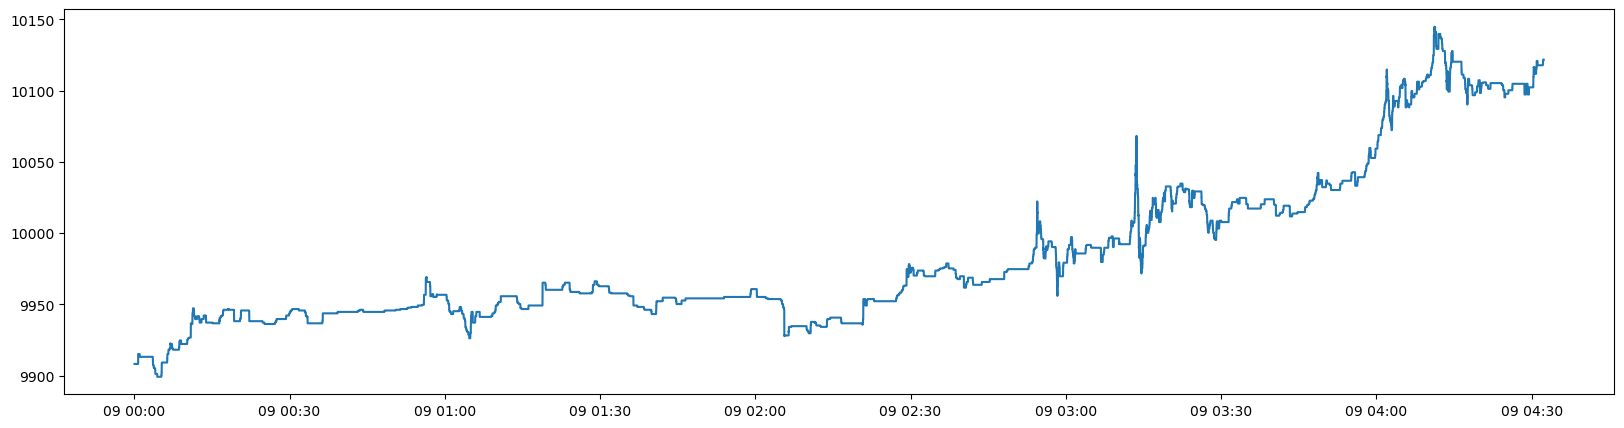

In [6]:
# reset the index to timestamp and plot the price change for the day
Xt = quotes.set_index('timestamp').midPrice
plt.rc('figure', figsize=(20, 5))
plt.plot(Xt)

## Phase 2: Avellaneda-Stoikov Parameter Calibration

The model is simplified to these equations:

$\textbf{Reserve Price:}$
$$r(s,q,t) = s - q \gamma \sigma^2 (T-t)$$

$\textbf{Bid-Ask Spread:}$

$$ \delta^{a} + \delta^{b} = \gamma \sigma^2 (T-t) + \frac{2}{\gamma} \ln(1 + \frac{\gamma}{k})$$

$\textbf{Bid Price:}$
$$r^{a}(s,q,t) = r(s,q,t) - \frac{1}{2}\delta$$

$\textbf{Ask Price:}$
$$r^{a}(s,q,t) = r(s,q,t) + \frac{1}{2}\delta$$

$\textbf{Assume Order Arrival Rate as:}$
$$\lambda^{a}(\delta) = \lambda^{b}(\delta) = Ae^{-k\delta}$$

s = current market mid price

q = quantity of assets in inventory of base asset (could be positive/negative for long/short positions)

σ = market volatility

T = closing time, when the measurement period ends (conveniently normalized to 1)

t = current time (T is normalized = 1, so t is a time fraction)

$\delta^a$, $\delta^b$ = bid/ask spread, symmetrical → δa=δb

γ = inventory risk aversion parameter

κ = order book liquidity parameter

### Now, we try to find parameters for XBT/USD to use in the Avellaneda-Stoikov Model
We need to find 3 parameters:
1) Volatility
2) Order Book liquidity
3) Inventory Aversion Parameter

### $\sigma$ Estimation
We assume that XBT/USD follows geometric brownian motion and so to find $\sigma$, we just calculate the standard deviation of log of mid_prices.

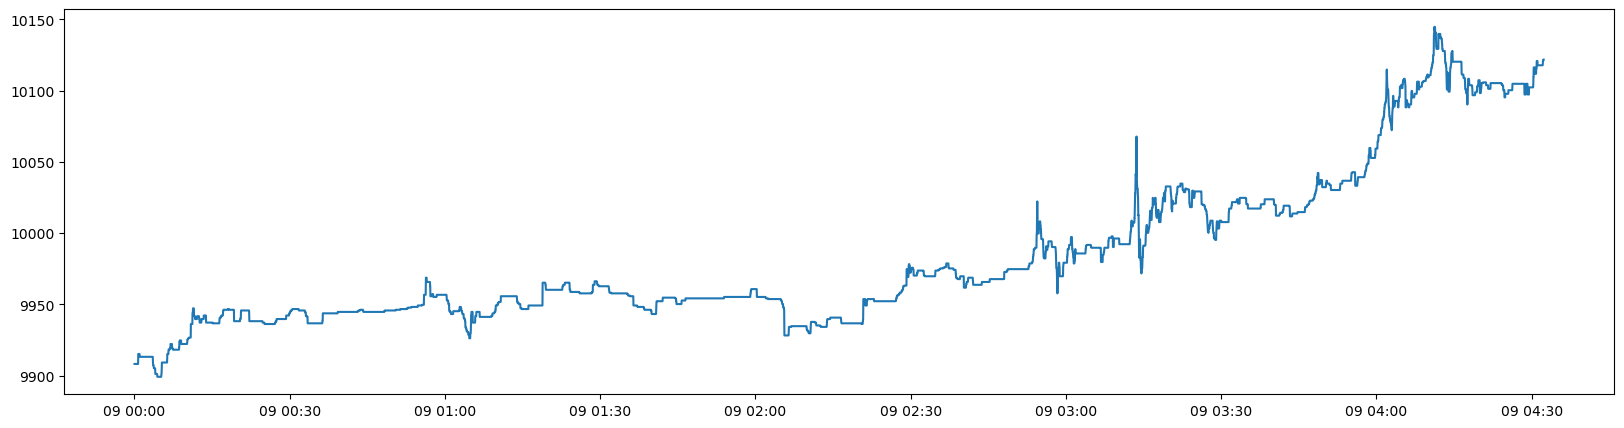

In [7]:
# resample prices with 1 second fixed interval
resample = Xt.resample('1S').last().bfill()
plt.plot(resample)

In [8]:
log_norm = np.log(resample).diff(1).dropna()
# calculate deviation
sigma = log_norm.std() * np.sqrt(3600*24)
print(sigma)

0.020959183855677677


### $k$ Estimation
We will plot the order arrival rate and do linear regression to find out the value of $k$

In [9]:
trades_filtered = trades[trades['size'] > 25] # filter out small trades

### Estimate trade intensity

In [10]:
# used to get bid price
def round_up(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return x + tick - remainder
# used to get ask price
def round_down(x, tick):
    remainder = x % tick
    if remainder == 0:
      return x
    else:
      return math.floor(x / tick) * tick

In [11]:
dT = 10
# number of samples
n = 0
T0 = quotes.iloc[0, :].timestamp
# end timestamp
T_final = quotes.iloc[-1, :].timestamp
# min tick size
tick = 0.5
# measured spread range
r = 40 # 40*0.5=20

T_start = T0
T_end = T_start + pd.Timedelta(seconds=dT)

ask_side_hits = np.array([])
bid_side_hits = np.array([])

while T_end < T_final:

    # reference price S(t)
    St = quotes[quotes.timestamp >= T_start].iloc[0, :].midPrice
    # ask side
    St_ask = round_down(St, tick)
    # get bids
    criteria_1 = (trades_filtered.timestamp >= T_start) # timestamp after T_start
    criteria_2 = (trades_filtered.timestamp < T_end) # timestamp before T_end
    criteria_3 = (trades_filtered.side == 'Buy') # "Buy"
    criteria_4 = (trades_filtered.price > St_ask) # price > St_ask
    criteria_5 = (trades_filtered.price <= St_ask + (r * tick)) # price must be lower than the measured spread range
    m_bids = trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_bids.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_bids.price.unique(), St_ask), tick)
        ask_side_hits = np.hstack([ask_side_hits, hits])

    # bid side
    St_bid = round_up(St, tick)
    # get asks
    criteria_1 = (trades_filtered.timestamp >= T_start) # timestamp after T_start
    criteria_2 = (trades_filtered.timestamp < T_end) # timestamp before T_end
    criteria_3 = (trades_filtered.side == 'Sell') # "Sell"
    criteria_4 = (trades_filtered.price < St_bid) # price < St_bid
    criteria_5 = (trades_filtered.price >= St_bid - (r * tick)) # price must be higher than the measured spread range
    m_asks = trades_filtered[criteria_1 & criteria_2 & criteria_3 & criteria_4 & criteria_5]

    if len(m_asks.index) > 0:
        # count ticks where marketable orders "hit"
        hits = np.floor_divide(np.subtract(m_asks.price.unique(), St_bid), -tick)
        bid_side_hits = np.hstack([bid_side_hits, hits])

    T_start = T_start + pd.Timedelta(seconds=dT)
    T_end = T_end + pd.Timedelta(seconds=dT)
    n = n + 1

print('done with {0} samples'.format(n))

done with 1633 samples


In [12]:
unique, counts = np.unique(ask_side_hits, return_counts=True)
ask_side_hits_agg = np.asarray((unique, counts)).T
unique, counts = np.unique(bid_side_hits, return_counts=True)
bid_side_hits_agg = np.asarray((unique, counts)).T
df_ask = pd.DataFrame(ask_side_hits_agg, columns=['tick', 'hits'])
df_bid = pd.DataFrame(bid_side_hits_agg, columns=['tick', 'hits'])
df_ask = df_ask.div([1, n])
df_ask = df_ask.rename(columns = {'hits': 'intensity'})
df_bid = df_bid.div([1, n])
df_bid = df_bid.rename(columns = {'hits': 'intensity'})

<Axes: xlabel='tick'>

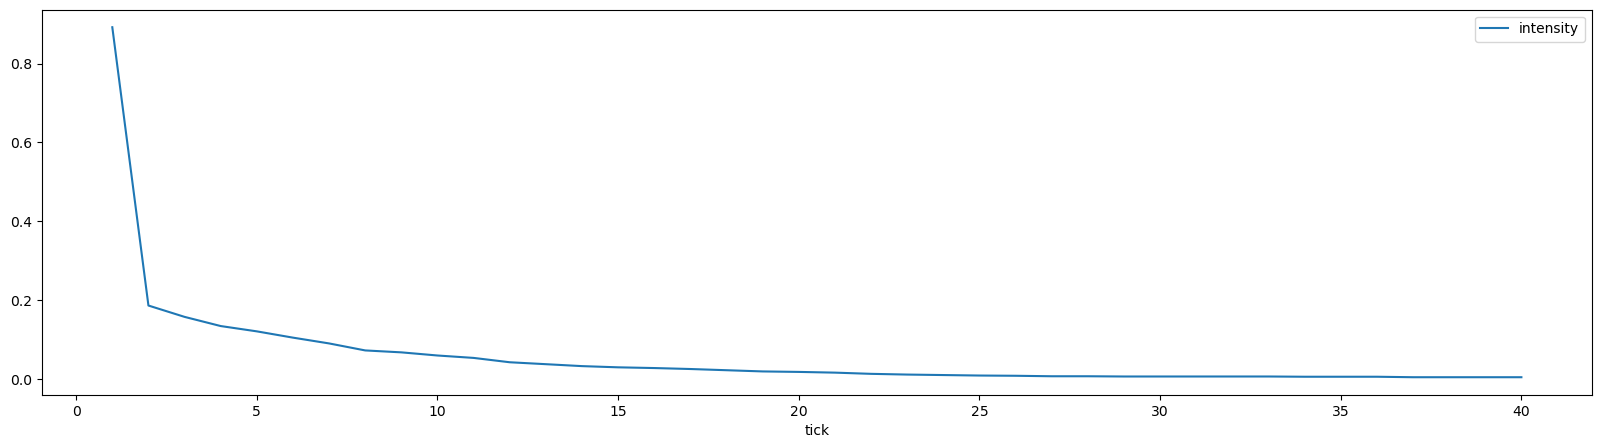

In [13]:
df_ask.plot(x='tick', y=['intensity'])

<Axes: xlabel='tick'>

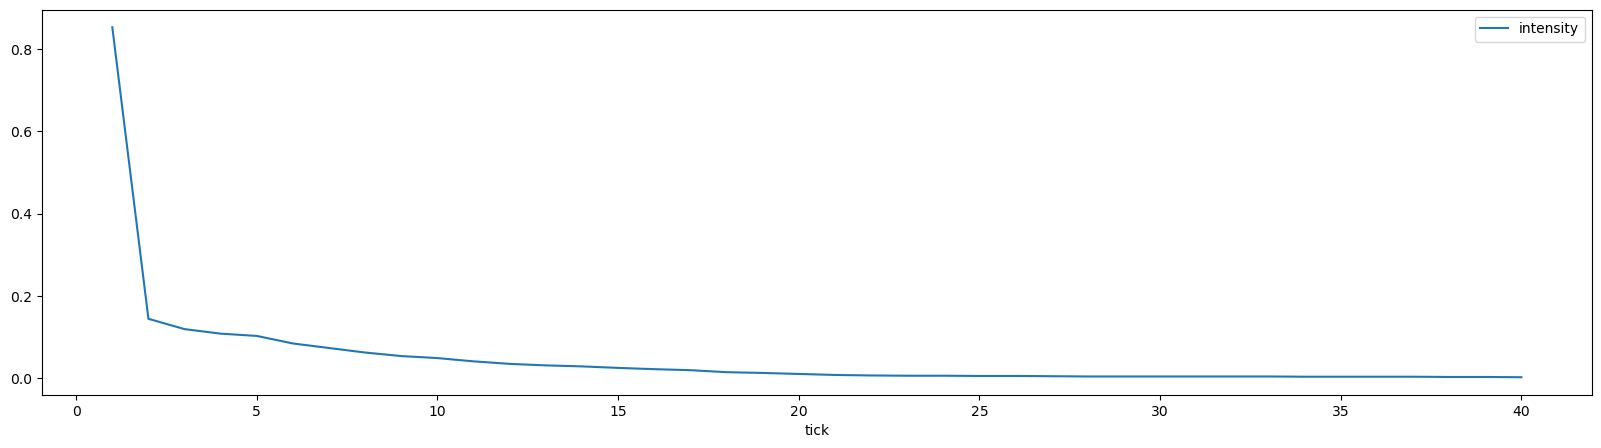

In [14]:
df_bid.plot(x='tick', y=['intensity'])

Order Arrival Intensity: $\lambda = Ae^{-k\delta}$ 

Or $log(\lambda) = -k\delta + logA$

In [15]:
# estimate k using linear regression
from sklearn.linear_model import LinearRegression
X = df_ask.tick.to_numpy()[:, np.newaxis]
y = np.log(df_ask.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_ask = - reg.coef_[0]
A_ask = np.exp(reg.intercept_)
print('k: ', k_ask)
print('A: ', A_ask)

r:  0.9247470024706146
k:  0.10926631695186384
A:  0.18958333647685852


In [16]:
X = df_bid.tick.to_numpy()[:, np.newaxis]
y = np.log(df_bid.intensity)
reg = LinearRegression().fit(X, y)
print('r: ', reg.score(X, y))
k_bid = - reg.coef_[0]
A_bid = np.exp(reg.intercept_)
print('k: ', k_bid)
print('A: ', A_bid)

r:  0.9229720133621407
k:  0.12257516381774637
A:  0.16477626558884387


In [17]:
k = np.mean([k_bid, k_ask])
A = np.mean([A_bid, A_ask])
print('k mean: ', k)
print('A mean: ', A)

k mean:  0.1159207403848051
A mean:  0.1771798010328512


In [18]:
A*np.exp(-k * np.arange(40.))
df_ask.loc[:, 'estimated'] = A*np.exp(-k * np.arange(40.))

<Axes: xlabel='tick'>

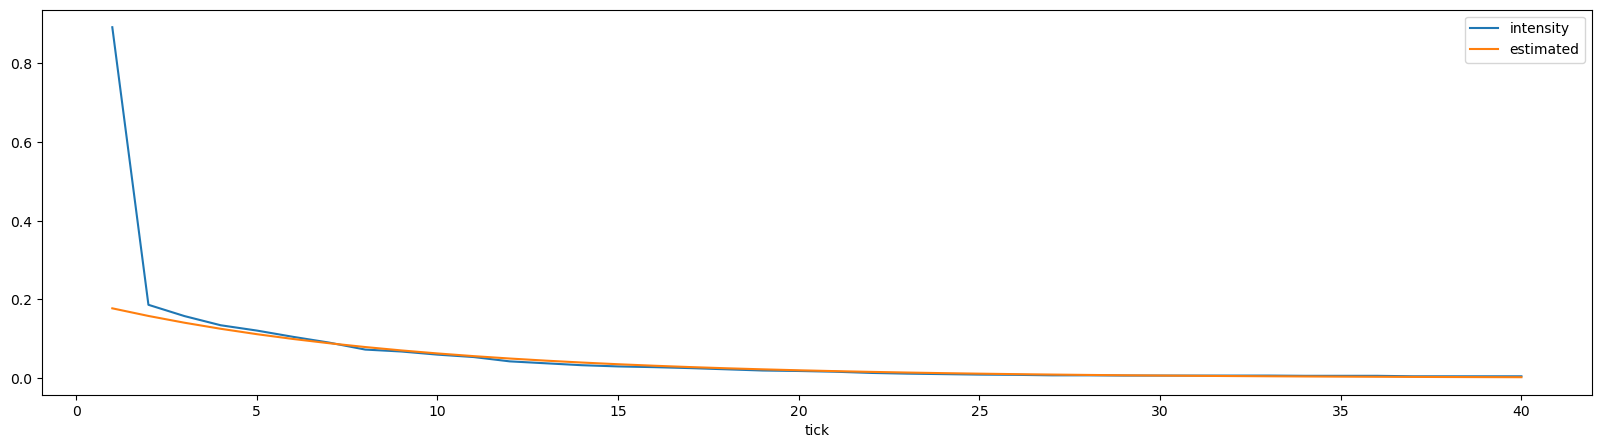

In [19]:
df_ask.plot(x='tick', y=['intensity', 'estimated'])

### Simulation to estimate $\gamma$
Here, we only use the inventory strategy as described in the paper.

In [20]:
def ast_sim(s0, T, sigma, dt, q0, gamma, k, A, sim_length):
    inventory = np.zeros(sim_length)
    pnl = np.zeros(sim_length)
    price_a = np.zeros((int(T / dt) + 1))
    price_b = np.zeros((int(T / dt) + 1))
    midprice = np.zeros((int(T / dt) + 1))
    for i in range(sim_length):
        # creating randomly simulated price process of an asset
        white_noise = sigma * np.sqrt(dt) * np.random.choice([1, -1], int(T / dt)) 
        price_process = s0 + np.cumsum(white_noise)
        price_process = np.insert(price_process, 0, s0)

        for step, s in enumerate(price_process):
            reservation_price = s - inventory[i] * gamma * sigma**2 * (T - step * dt)
            spread = gamma * sigma**2 * (T - step * dt) + (2 / gamma) * np.log(1 + (gamma / k))
            spread /= 2
    
            if reservation_price >= s:
                    ask_spread = spread + (reservation_price - s)
                    bid_spread = spread - (reservation_price - s)
            else:
                ask_spread = spread - (s - reservation_price)
                bid_spread = spread + (s - reservation_price)
            ask_prob = A * np.exp(- k * ask_spread) * dt
            bid_prob = A * np.exp(- k * bid_spread) * dt
            ask_prob = max(0, min(ask_prob, 1)) # ensure ask_prob between 0 and 1
            bid_prob = max(0, min(bid_prob, 1)) # ensure bid_prob between 0 and 1
    
            ask_action = np.random.choice([1, 0], p=[ask_prob, 1 - ask_prob])
            bid_action = np.random.choice([1, 0], p=[bid_prob, 1 - bid_prob])
    
            inventory[i] -= ask_action # selling the asset
            inventory[i] += bid_action # buying the asset

            pnl[i] += ask_action * (s + spread) # pnl increased by selling assets
            pnl[i] -= bid_action * (s - spread) # pnl decreased by buying assets

            if i == 0:
                price_a[step] = s + ask_spread
                price_b[step] = s - bid_spread
                midprice[step] = s
        
        pnl[i] += inventory[i]*s
    x_range = [-50, 150]
    y_range = [0, 250]
    plt.figure(figsize=(16, 12), dpi=100)
    bins = np.arange(x_range[0], x_range[1] + 1, 4)
    plt.hist(pnl, bins=bins, alpha=0.25, label="Inventory strategy")
    plt.ylabel('P&l')
    plt.legend()
    plt.axis(x_range + y_range)
    plt.title("The P&L histogram of the strategy")

    x = np.arange(0, T + dt, dt)
    plt.figure(figsize=(16, 12), dpi=100)
    plt.plot(x, price_a, linewidth=1.0, linestyle="-",
             label="ASK")
    plt.plot(x, price_b, linewidth=1.0, linestyle="-",
             label="BID")
    plt.plot(x, midprice, linewidth=1.0, linestyle="-",
             label="MID-PRICE")
    plt.legend()
    plt.title("The mid-price and the optimal bid and ask quotes")
    print("P&L - Mean of the strategy: "
          "{}".format(np.array(pnl).mean()))
    print("P&L - Standard deviation of the strategy: "
          "{}".format(np.sqrt(np.array(pnl).var())))
    return np.array(pnl).mean()

#### Simulation using parameters from the Avellaneda-Stoikov Paper

P&L - Mean of the strategy: 72.4564103549702
P&L - Standard deviation of the strategy: 7.13924804264699


72.4564103549702

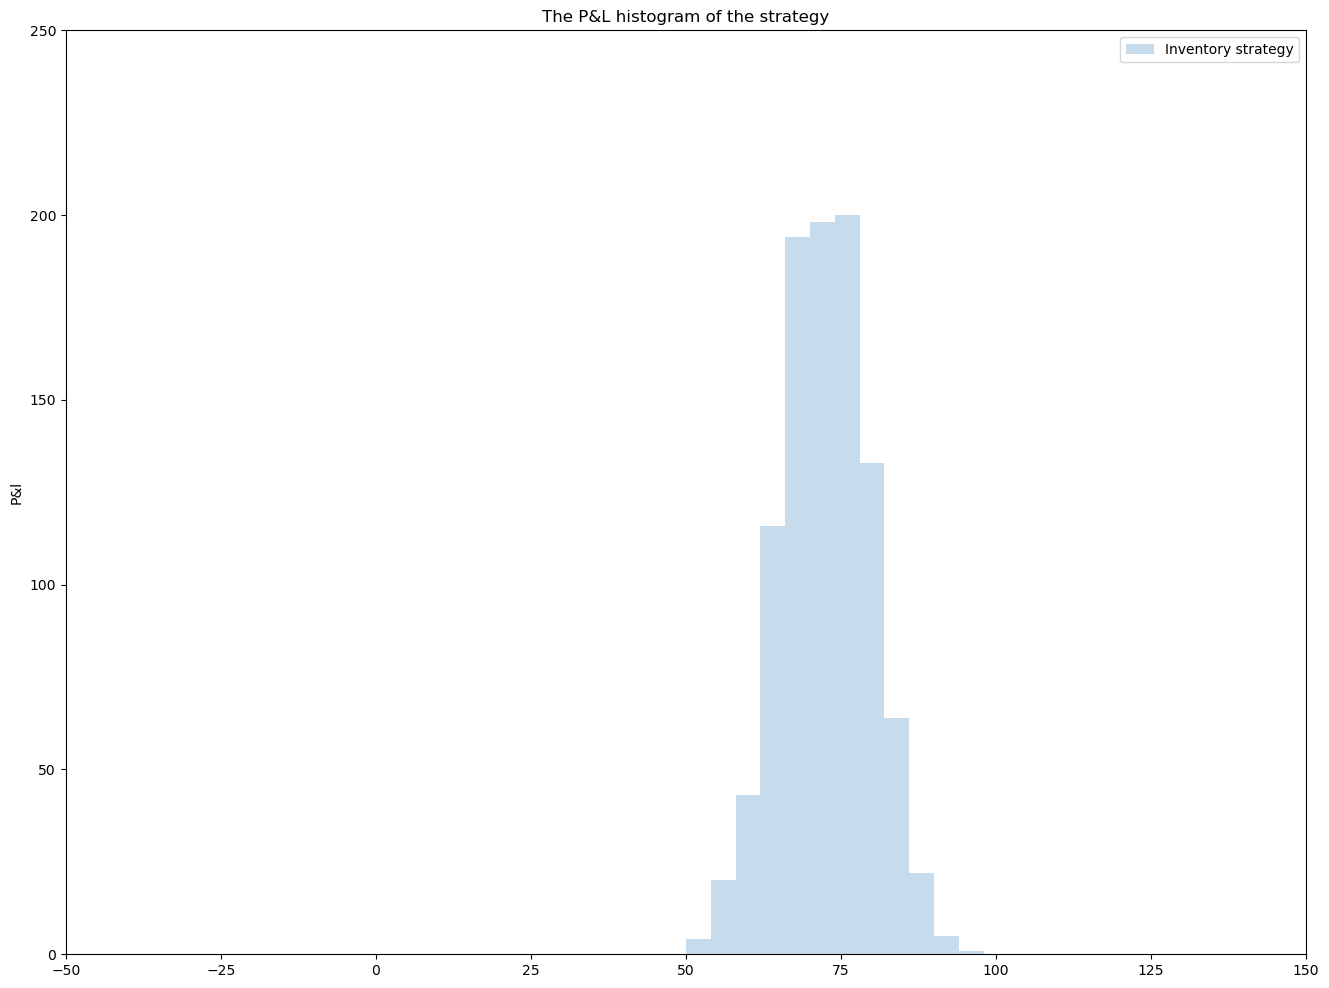

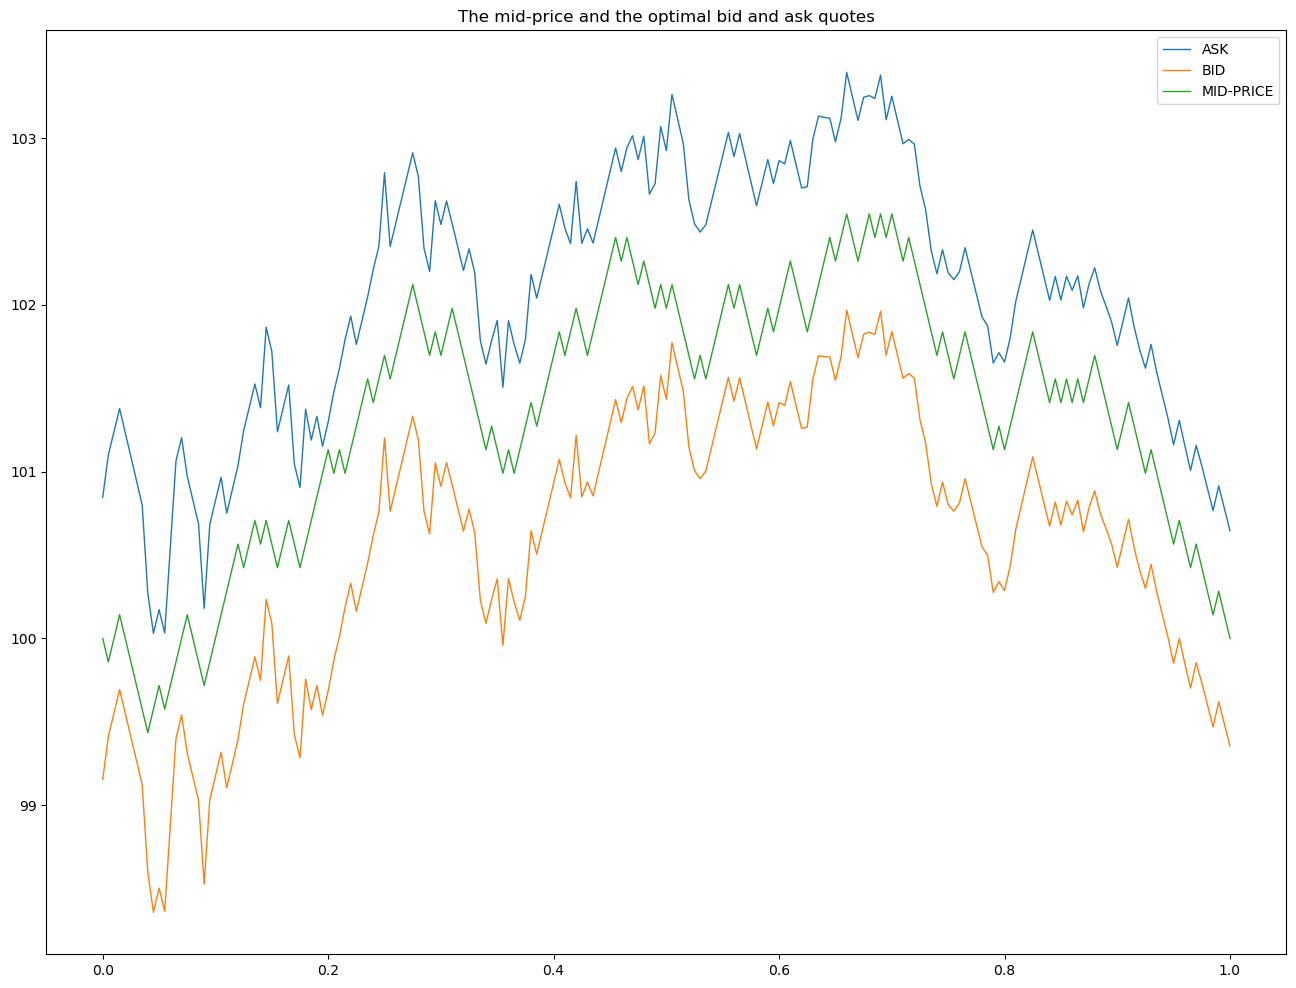

In [21]:
ast_sim(100, 1, 2, 0.005, 0, 0.1, 1.5, 140, 1000)

#### Simulation using parameters that we have calibrated from BTC/USD

For example, using $\gamma = 0.5$

P&L - Mean of the strategy: 0.7751494606654865
P&L - Standard deviation of the strategy: 1.5388341048823662


0.7751494606654865

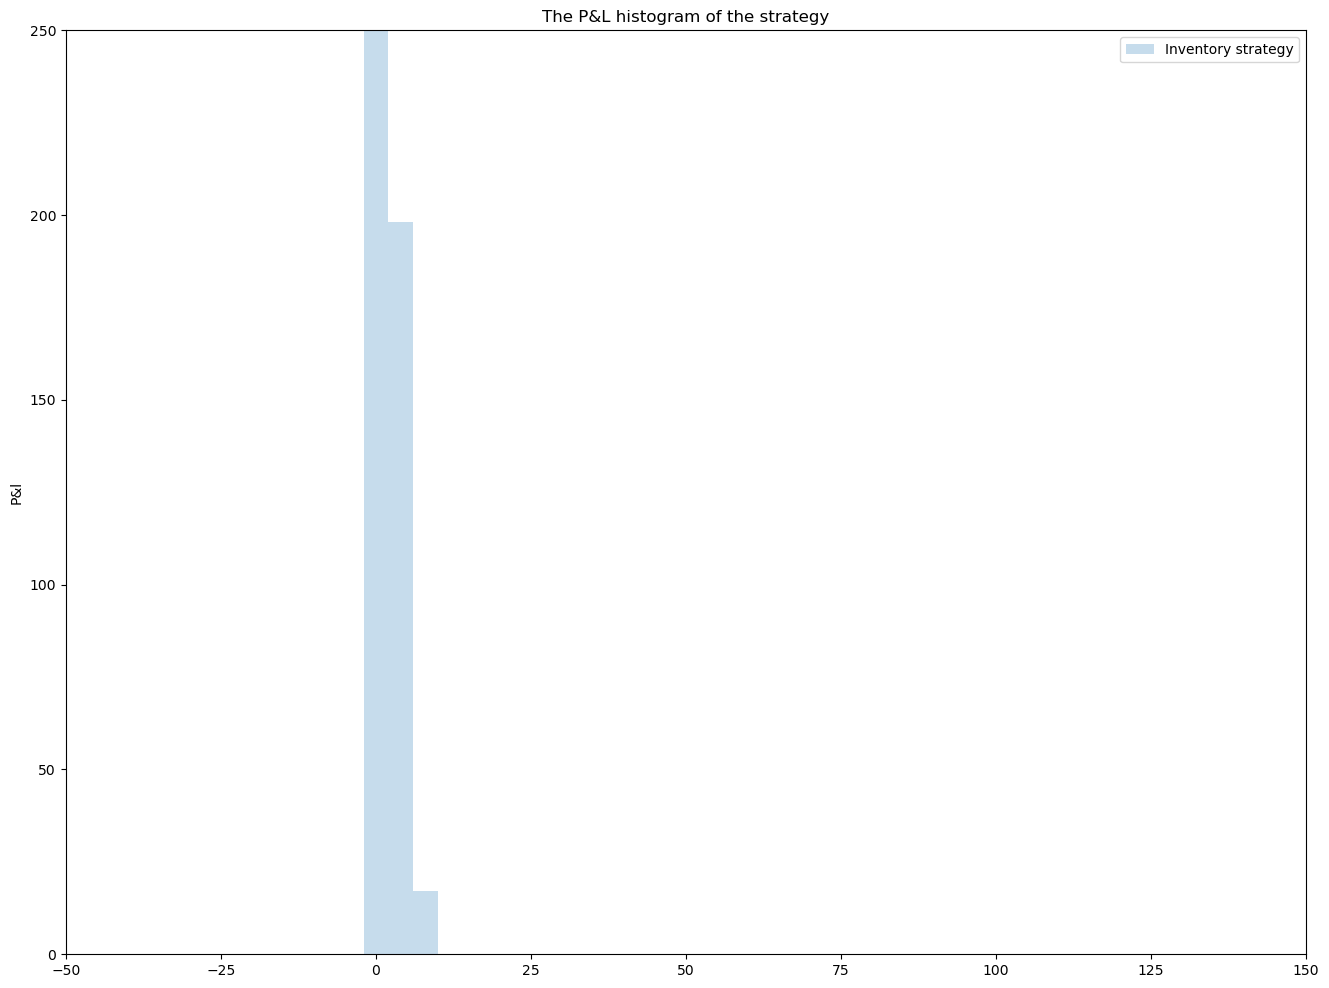

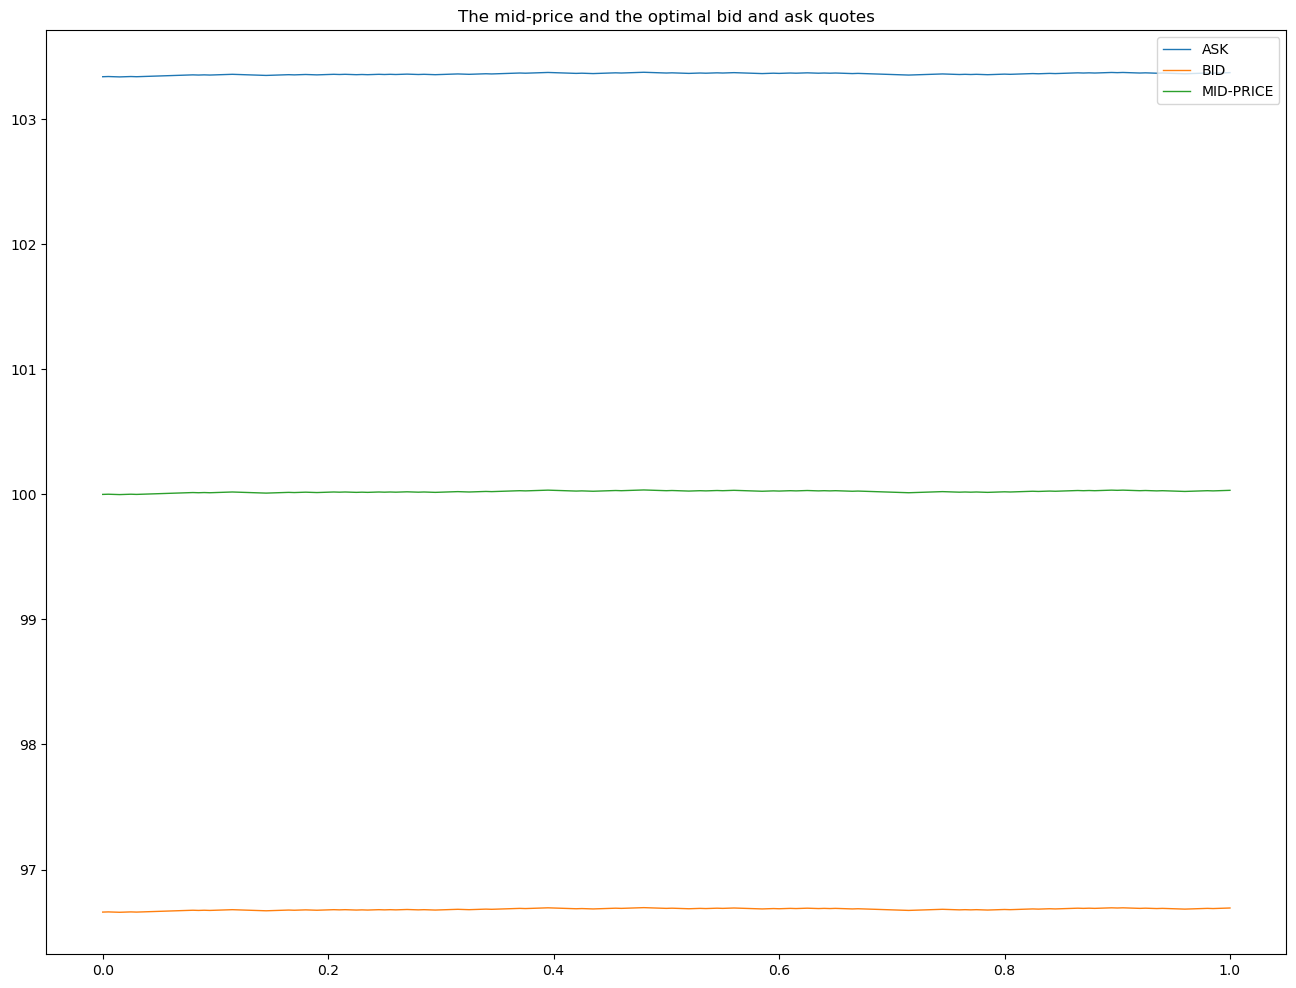

In [22]:
ast_sim(100, 1, 0.020959183855677677, 0.005, 0, 0.5, 0.1159207403848051, 0.1771798010328512, 1000)

In [ ]:
# This function is very slow and only for analysis purposes. Actually, finding gamma is very tough and mostly found
# through emprical experiments.
gamma_range = np.linspace(0.01, 1, 20)  # Adjust the number of points as needed

# Collect P&L means for each gamma value
pnl_means = []
for gamma in gamma_range:
    pnl_mean = ast_sim(100, 1, 0.020959183855677677, 0.005, 0, gamma, 0.1159207403848051, 0.1771798010328512, 1000)
    pnl_means.append(pnl_mean)

# Plot P&L vs. gamma
plt.figure(figsize=(10, 6))
plt.plot(gamma_range, pnl_means, marker='o', linestyle='-')
plt.xlabel('Gamma')
plt.ylabel('P&L Mean')
plt.title('P&L Mean vs. Gamma')
plt.grid(True)
plt.savefig('pnl_vs_gamma.png')
plt.show()

![SNOWFALL](pnl_vs_gamma.png) 

P&L - Mean of the strategy: 1.03429375113008
P&L - Standard deviation of the strategy: 2.7861775307051597


1.03429375113008

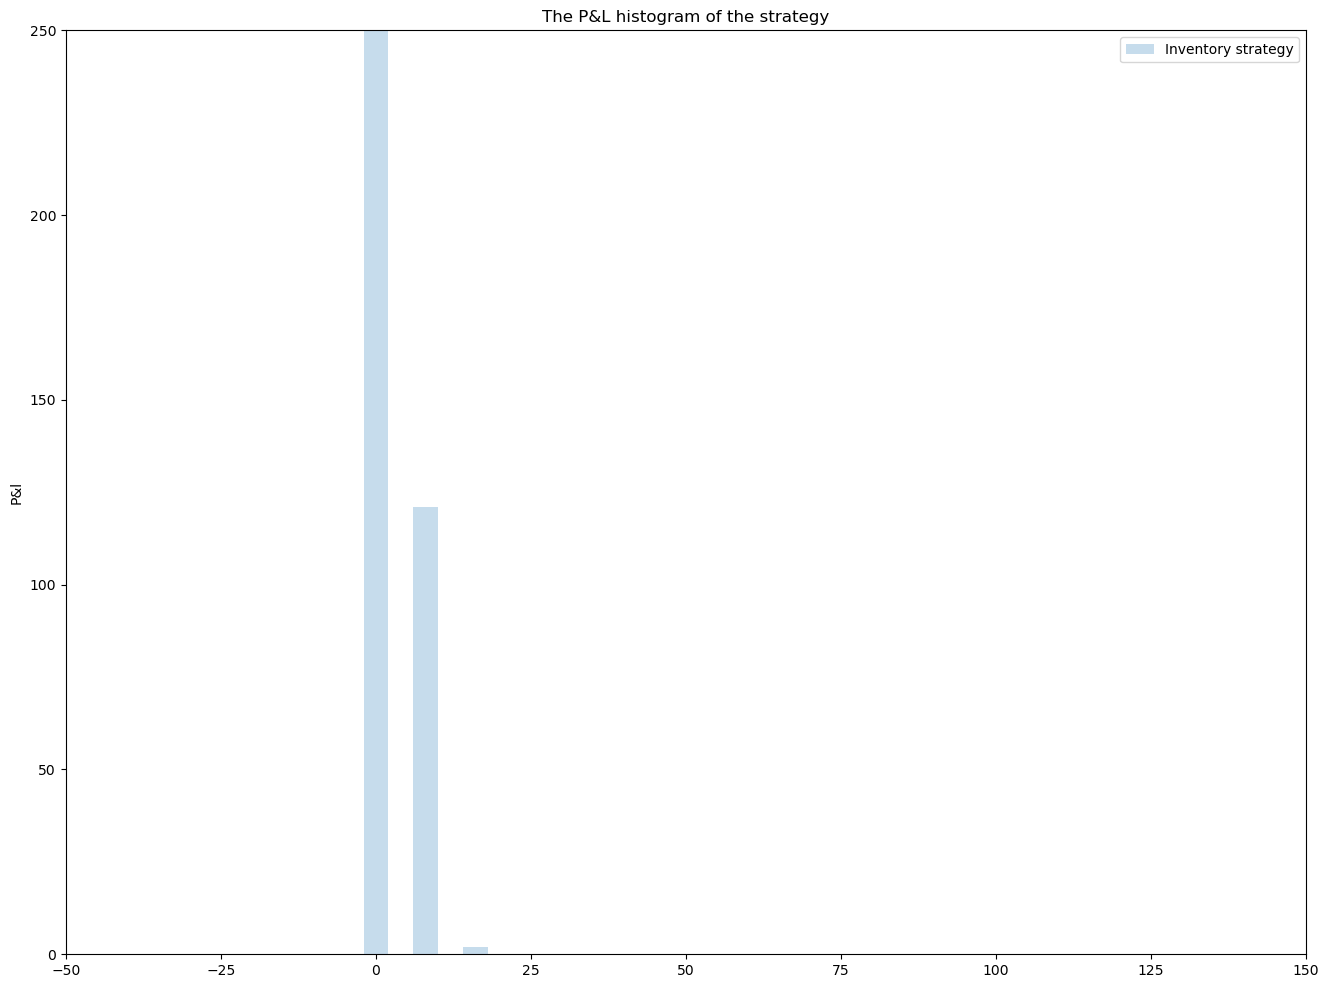

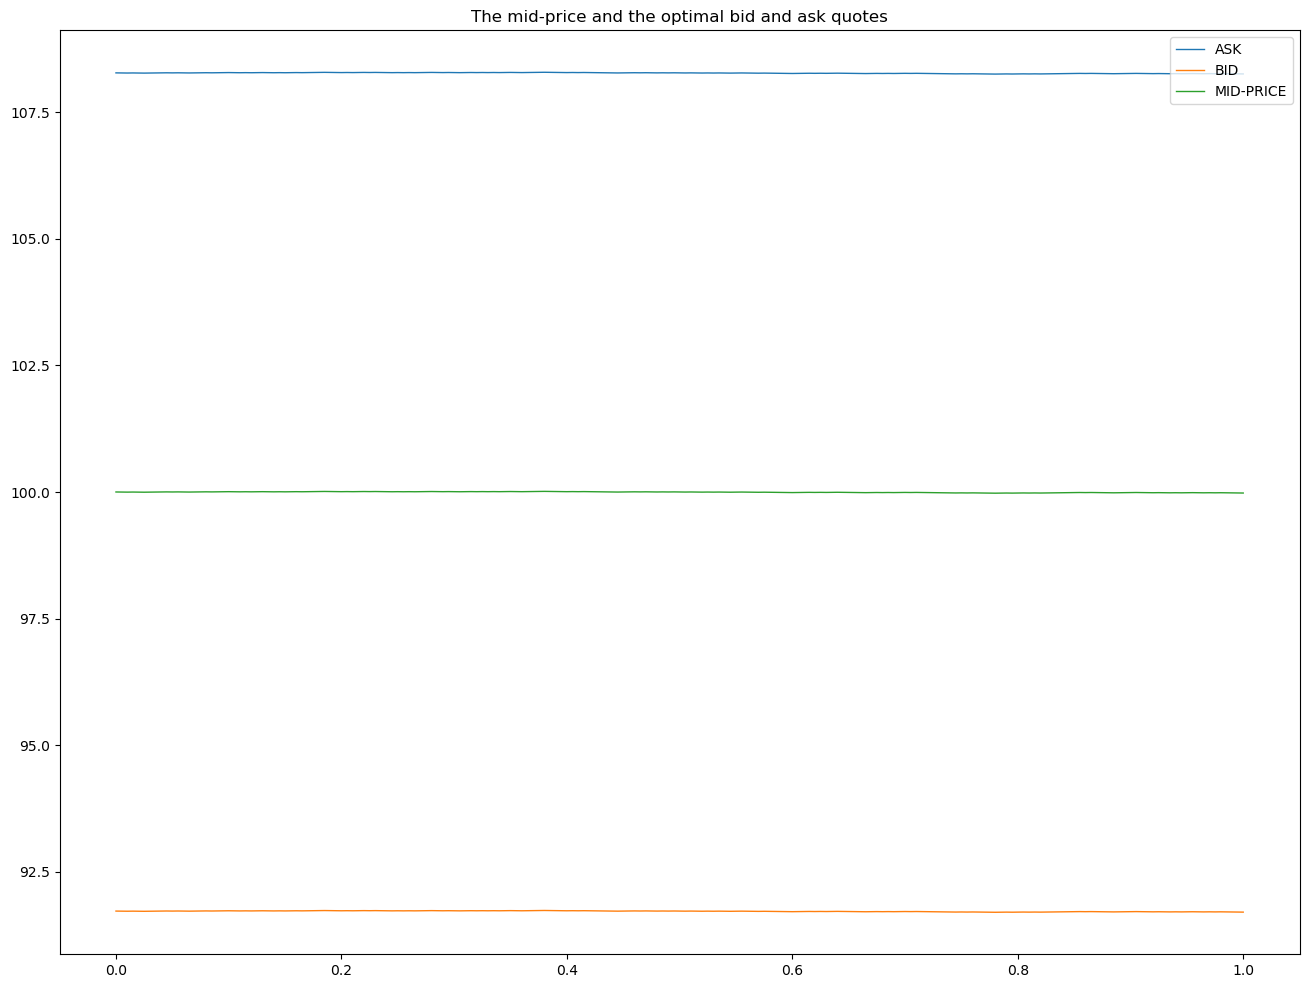

In [23]:
# Trying with gamma = 0.01
ast_sim(100, 1, 0.020959183855677677, 0.005, 0, 0.01, 0.1159207403848051, 0.1771798010328512, 1000)

From these graphs, we can infer that liquidity is low in BTC/USD as there is significant difference between the bid and the ask prices.